In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torch.nn.functional as F
import sys
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
GIT_ROOT = Path("../..").resolve()
print(GIT_ROOT)
SRC = GIT_ROOT / "src"
if not SRC in sys.path:
    sys.path.append(str(SRC))

c:\Users\salom\anaconda3\envs\KEX\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\salom\Documents\code\KTH\KEX---CT-reconstruction


In [16]:
import torch
import matplotlib.pyplot as plt
from geometries.data import get_htc2022_train_phantoms, get_kits_train_phantoms
from utils.polynomials import Chebyshev, Legendre
from utils.tools import MSE
from geometries import HTC2022_GEOMETRY, CDTYPE, get_moment_mask, DEVICE


##CONFIG
geometry = HTC2022_GEOMETRY
ar = 0.05
M, K = 50, 50
PolynomialFamily = Chebyshev
##

In [21]:
from geometries.extrapolation import FastSinoFilling, DTYPE, CDTYPE

print(DTYPE, CDTYPE, ar)
known_angles = torch.zeros(geometry.n_projections, dtype=torch.bool)
known_angles[:geometry.n_known_projections(ar)] = 1
filler = FastSinoFilling(geometry, known_angles, M, K, Chebyshev)
filler._compute_system_matrix()
print(filler.normal_matrix.dtype)

torch.float32 torch.complex64 0.05


constructing normal matrix for sinogram extrapolation: 650it [05:56,  1.82it/s]

torch.complex64


torch.float32 torch.complex64 0.05
tensor(2.1868)
tensor(0.1660)
tensor(0.1620)
tensor(0.0788)
tensor(0.0002, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)


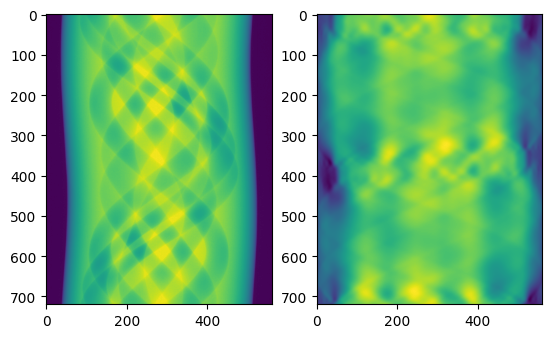

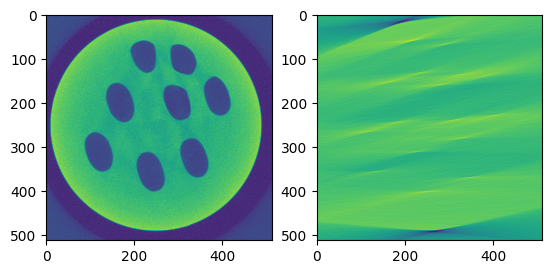

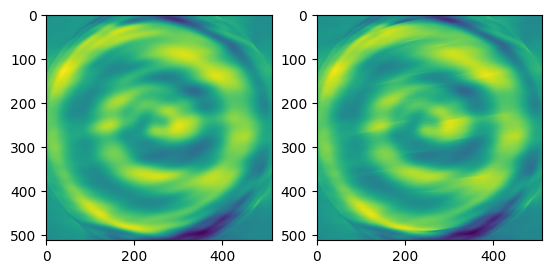

In [22]:
from geometries.data import get_htc_traindata, DTYPE
print(DTYPE, CDTYPE, ar)
kits = get_kits_train_phantoms(resize=True)[:5]
kits_sinos = geometry.project_forward(kits)

sinos, phantoms = get_htc_traindata()
sinos = sinos.to(DTYPE)
la_sinos, known_angles = geometry.zero_cropp_sinos(sinos, ar, 0)
exp = filler.forward(la_sinos)
recons = geometry.fbp_reconstruct(exp)
exp2 = la_sinos+0
exp2[:, ~known_angles] = exp[:, ~known_angles]
recons2 = geometry.fbp_reconstruct(exp2)
recons3 = geometry.fbp_reconstruct(la_sinos)

print(MSE(la_sinos, sinos))
print(MSE(exp, sinos))
print(MSE(sinos, exp2))
print(MSE(sinos[:, known_angles], exp[:, known_angles]))
print(MSE(recons, phantoms))
print(MSE(recons2, phantoms))
print(MSE(recons3, phantoms))

plt.subplot(121)
plt.imshow(sinos[1])
plt.subplot(122)
plt.imshow(exp[1])
plt.figure()
plt.subplot(121)
plt.imshow(phantoms[1])
plt.subplot(122)
plt.imshow(recons3[1])
plt.figure()
plt.subplot(121)
plt.imshow(recons[1])
plt.subplot(122)
plt.imshow(recons2[1])

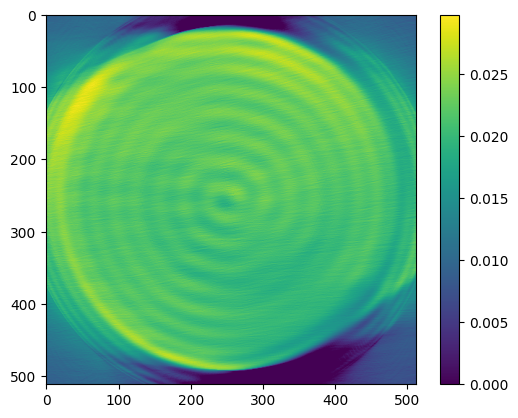

In [25]:
from torch.nn.functional import relu

plt.imshow(relu(recons2[0]))
plt.colorbar()

In [4]:

##data
kits = torch.load(GIT_ROOT / "data/kits_phantoms_256.pt")
N, c, h, w = kits.shape
print(kits.shape)
kits = kits.reshape((N*c,h,w))
resized = torchvision.transforms.functional.resize(kits, (512, 512))
print(resized.shape)

plt.imshow(resized[700].cpu())

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [6]:
sinos = geometry.project_forward(resized)
print("sinos computed")
la_sinos, knwon_angles = geometry.zero_cropp_sinos(sinos, ar, 0)
n_known_betas = geometry.n_known_projections(ar)
batch_size = la_sinos.shape[0]

n_iters = 30
cn = torch.zeros((batch_size, M, K), device=DEVICE, dtype=CDTYPE)
mask = get_moment_mask(cn)
for it in range(n_iters):
    composed = geometry.synthesise_series(cn, PolynomialFamily)
    composed[:, n_known_betas:] *= 0
    print("it:", it, "MSE:", MSE(composed, la_sinos))
    cn[:, mask] += geometry.series_expand(la_sinos-composed)[:, mask]

sinos computed
it: 0 MSE: tensor(142.3576)


TypeError: FlatFanBeamGeometry.series_expand() missing 2 required positional arguments: 'PolynomialBasis' and 'n_degs'

In [ ]:
phantoms = get_htc2022_train_phantoms()
print("phantoms loaded")
sinos = geometry.project_forward(phantoms)
la_sinos, known_angles = geometry.zero_cropp_sinos(sinos, ar, 0)

N, Nu, Nb = sinos.shape
n_known_u = geometry.n_known_projections(ar)

mask = get_moment_mask(torch.zeros((1,M,K)))
n_coeffs = mask.sum()
print(n_coeffs, M*(M+1)//2)
coefficients = torch.zeros((N, n_coeffs), dtype=CDTYPE, requires_grad=False)

l1 = 1e-3

n_iters = 100

for it in range(n_iters):

    embedding = torch.zeros((N, M, K), dtype=CDTYPE)
    embedding[:, mask] += coefficients
    res = geometry.synthesise_series(embedding, Legendre)
    loss = MSE(res[:, :n_known_u], la_sinos[:, :n_known_u]) #+ l1*torch.mean(torch.abs(coefficients)**2)

    err = la_sinos - res
    err[:, n_known_u:] *= 0
    coefficients += geometry.series_expand(err, Legendre, M, K)[:, mask]
    print("iter:", it, "loss:", loss.item())

# exp = la_sinos + 0
embedding = torch.zeros((N, M, K), dtype=CDTYPE)
embedding[:, mask] += coefficients
exp = geometry.synthesise_series(embedding, Legendre)
recons = geometry.fbp_reconstruct(exp)
print("exp error:", MSE(exp, sinos))
print("recons error:", MSE(recons, phantoms))

disp_ind = 0
plt.subplot(121)
plt.imshow(sinos[disp_ind])
plt.subplot(122)
plt.title("exp")
plt.imshow(exp[disp_ind].detach())

plt.figure()
plt.subplot(121)
plt.imshow(recons[disp_ind])
plt.subplot(122)
plt.title("gt")
plt.imshow(phantoms[disp_ind])

plt.show()

for i in plt.get_fignums():
    fig = plt.figure(i)
    title = fig._suptitle.get_text() if fig._suptitle is not None else f"fig{i}"
    plt.savefig(f"{title}.png")







In [4]:
import torch

sinos = torch.load(r"C:\Users\salom\Documents\code\KTH\KEX---CT-reconstruction\data\HTC2022\HTCTestDataLimited.pt")

print(len(sinos))

print([tuple(si.shape) for si in sinos])
print(set([tuple(si.shape) for si in sinos]))




21
[(181, 560), (161, 560), (141, 560), (121, 560), (101, 560), (81, 560), (61, 560), (181, 560), (161, 560), (141, 560), (121, 560), (101, 560), (81, 560), (61, 560), (181, 560), (161, 560), (141, 560), (121, 560), (101, 560), (81, 560), (61, 560)]
{(121, 560), (101, 560), (161, 560), (61, 560), (81, 560), (141, 560), (181, 560)}


### Lengths

- 181
- 161
- 141
- 121
- 101
- 81
- 61